# Distortion Classification

In [1]:
import torch
import torchaudio
import os

#### Add Tensorboard to record data

In [2]:
from torch.utils.tensorboard import SummaryWriter

EXPERIMENT_NAME = "c53_classify_od_mfcc"
LOG_DIR = "_log/" + EXPERIMENT_NAME
EVU_DIR = "_log/Evaluation/"

if not os.path.exists('%s' % LOG_DIR):
    os.makedirs('%s' % LOG_DIR)

if not os.path.exists('%s' % EVU_DIR):
    os.makedirs('%s' % EVU_DIR)

log_writer = SummaryWriter(LOG_DIR)


### Load dataset

Using device cpu
There are 3915 samples in the dataset.
Shape of signal: torch.Size([1, 64, 64])
input feature:


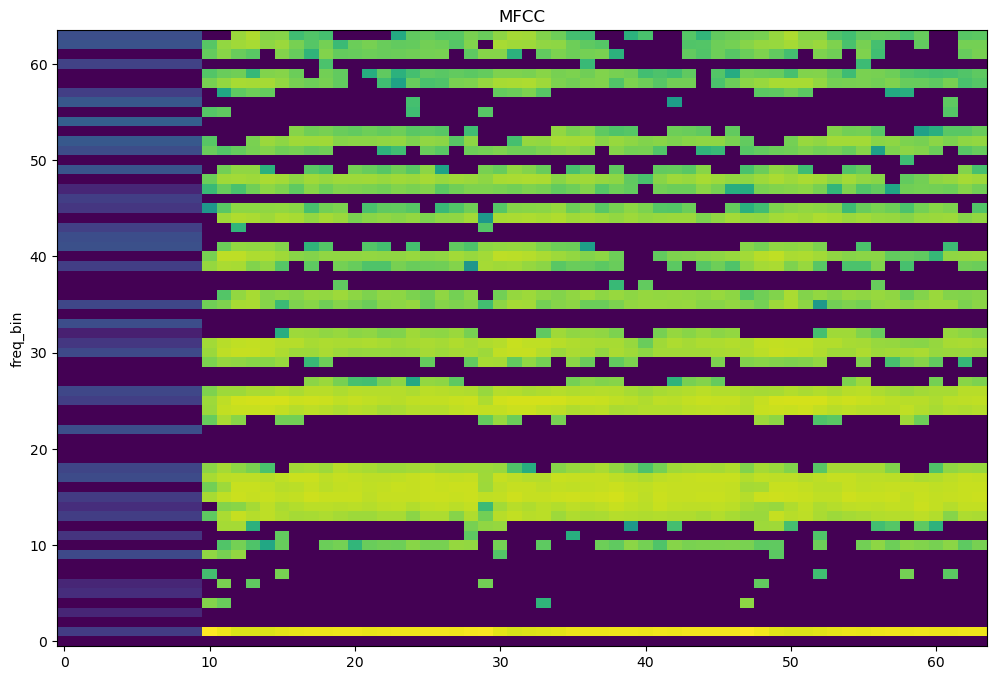

In [3]:
from src.gtfxdataset import GtFxDataset
from src.util import plot_spectrogram

AUDIO_DIR = "_assets/DATASET/GT-FX-C53/"
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "annotation.csv")

SAMPLE_RATE = 22050
NUM_SAMPLES = 22050*3

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=1048,
    n_mels=64,
)

spectrogram = torchaudio.transforms.Spectrogram(
    power=2.0,
    n_fft=127,
    win_length= 127,
    hop_length= 1048,
    normalized=True
)

mfcc = torchaudio.transforms.MFCC(
    sample_rate = SAMPLE_RATE, 
    n_mfcc = 64,
    melkwargs = {
        "n_fft": 1024,
        "hop_length": 1024,
        "n_mels": 64,
        "center": False})

fxData = GtFxDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

fxData, _ = torch.utils.data.random_split(fxData, lengths=[0.01, 0.99])

signal, _, _, _, filename = fxData[0]
print(f"There are {len(fxData)} samples in the dataset.")
print(f"Shape of signal: {signal.shape}")

print("input feature:")
log_writer.add_figure("Input Feature", plot_spectrogram(signal[0], title="MFCC"))

#### Split dataset into train and test sets

In [4]:
from src.classifier import train

BATCH_SIZE = round(len(fxData) / 200)

split_ratio = [0.8, 0.1, 0.1]
train_set, test_set, val_set = torch.utils.data.random_split(fxData, lengths=split_ratio)

train_dataloader = train.create_data_loader(train_set, BATCH_SIZE)
test_dataloader = train.create_data_loader(test_set, BATCH_SIZE)
val_dataloader = train.create_data_loader(val_set, BATCH_SIZE)

#### Model training

In [5]:
from src.classifier import model
from torch import nn

LEARNING_RATE = 0.0002
EPOCHS = 5

WEIGHTS_DIR = "_weights/"
WEIGHTS_PATH = os.path.join(WEIGHTS_DIR, EXPERIMENT_NAME)

if not os.path.exists('%s' % WEIGHTS_DIR):
    os.makedirs('%s' % WEIGHTS_DIR)

# construct model and assign it to device
cnn = model.SingleClassifier().to(device)

log_writer.add_graph(cnn, signal.unsqueeze_(0))

# initialise loss funtion + optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# train model
train.train(cnn,
            train_dataloader,
            test_dataloader,
            loss_fn,
            optimiser,
            device,
            log_writer,
            EPOCHS,
            WEIGHTS_PATH,
            mode="single")


Epoch 1
loss: 0.692459  [  0/3133]
loss: 0.227890  [400/3133]
loss: 0.235991  [800/3133]
loss: 0.391529  [1200/3133]
loss: 0.255214  [1600/3133]
loss: 0.086845  [2000/3133]
loss: 0.465594  [2400/3133]
loss: 0.238095  [2800/3133]
Accuracy: 95.4%, avg loss: 0.117338
learning rate: 0.000200 -> 0.000182
---------------------------

Epoch 2
loss: 0.051693  [  0/3133]
loss: 0.150044  [400/3133]
loss: 0.106894  [800/3133]
loss: 0.060552  [1200/3133]
loss: 0.019750  [1600/3133]
loss: 0.028378  [2000/3133]
loss: 0.049202  [2400/3133]
loss: 0.059836  [2800/3133]
Accuracy: 97.2%, avg loss: 0.080168
learning rate: 0.000182 -> 0.000164
---------------------------

Epoch 3
loss: 0.089370  [  0/3133]
loss: 0.017184  [400/3133]
loss: 0.140376  [800/3133]
loss: 0.029236  [1200/3133]
loss: 0.194270  [1600/3133]
loss: 0.100960  [2000/3133]
loss: 0.040827  [2400/3133]
loss: 0.024720  [2800/3133]
Accuracy: 99.2%, avg loss: 0.030161
learning rate: 0.000164 -> 0.000146
---------------------------

Epoch 4
lo

#### Evaluation

Accuracy: 99.7%, avg loss: 0.020252
[[185   1]
 [  0 205]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       186
           1       1.00      1.00      1.00       205

    accuracy                           1.00       391
   macro avg       1.00      1.00      1.00       391
weighted avg       1.00      1.00      1.00       391



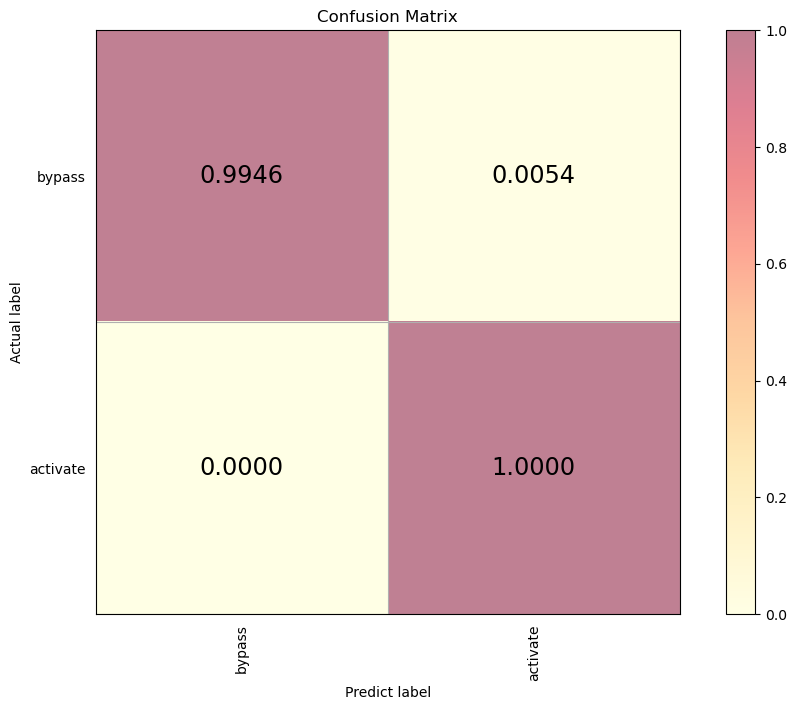

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
from src.util import plot_confusion_matrix
import numpy as np

labels_ID = ['bypass', 'activate']

cnn = model.SingleClassifier().to(device)

state_dict = torch.load(WEIGHTS_PATH + "_5.pth")
cnn.load_state_dict(state_dict)

_, _, log = train.test(cnn, val_dataloader, device, mode="single")

expected = []
predicted = []
for index, data in enumerate(log):
    predicted.append(data[1])
    expected.append(data[2])

arr = np.array([predicted, expected])
np.save(EVU_DIR + EXPERIMENT_NAME + "_evaluation.npy", arr)

mat_con = confusion_matrix(y_true=expected, y_pred=predicted)
print(mat_con)
print(classification_report(expected, predicted))

log_writer.add_figure("Confusion Matrix", plot_confusion_matrix(mat_con, title='Confusion Matrix', classes=labels_ID))

log_writer.close()